# <div align="center"> CNN可视化: Gradient-weighted Class Activation Mapping (Grad-CAM) </div>

## 导图

### 论文树图

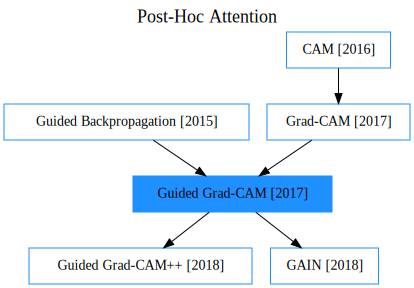

In [1]:
from graphviz import Source
graph = '''digraph G {
    center = true  
    fontsize = 18  fontcolor = "#00000000"
    labelloc = top  labeljust = center
    label = "Post-Hoc Attention"
    node [shape=rectangle, color=dodgerblue]
    a [label="Guided Backpropagation [2015]"]
    b [label="CAM [2016]"]
    c [label="Grad-CAM [2017]"]
    d [label="Guided Grad-CAM [2017]" style=filled]
    e [label="Guided Grad-CAM++ [2018]"]
    f [label="GAIN [2018]"]
    
    a -> d
    b -> c
    c -> d
    d -> e
    d -> f
}'''
Source(graph)

## 描述

管Grad-CAM可视化具有类别判别能力，并能很好地定位相关图像区域，但它们缺乏像像素空间梯度可视化方法（导向反向传播和反卷积）那样显示细粒度重要性的能力, 所以Guided Grad-CAM诞生了.

Guided Grad-CAM 是Grad-CAM和Guided Backpropagation的结合(Grad-CAM $\odot$ Guided Backpropagation)

## 模型

![](https://gitee.com/qrsforever/blog_source_assets/raw/master/AI/post-hoc/grad-cam.png)

$$
\begin{align*}
L_{Grad-CAM}^c &= ReLU\big( \sum_{k}^K \alpha_k^c A^k \big) \\
\alpha_k^c &= \dfrac{1}{Z} \sum_i^u \sum_j^v \dfrac{\partial y^c}{\partial {A_{ij}^c}} \\
L_{Guided-Grad-CAM}^c &= R^0 \odot L_{Grad-CAM}^c 
\end{align*}
$$

符号|描述
:--:|:----
<img width=200/>|<img width=400/>
A|特征图(feature map)
K|卷积的特征图的数目(number of feature maps)
u|特征图的宽(width)
v|特征图的高(height)
Z|Z = u*v 表示特征图的像素数 $\sum_{i=1}^{u}\sum_{j=1}^{v} 1$
c|分类类别值(如:Australian terrier)
$y^c$|c分类分数值(classification scores)
$\alpha_k^c$|对特征梯度均值化后, 作为特征A的权重 (梯度权重)
$L_{Grad-CAM}^c$|加权梯度CAM目标分类位置热图
$R^0$|导向反向传播(Guided Backpropagation)重构的图

## 代码演示

### 导入库

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os, io
import numpy as np
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torchvision import transforms, models
from torch.nn import functional as F
from PIL import Image
from IPython.display import display, HTML

In [4]:
np.__version__, torch.__version__, torchvision.__version__, PIL.__version__

('1.18.2', '1.5.0.dev20200319', '0.6.0.dev20200319', '7.0.0')

### 加载图片

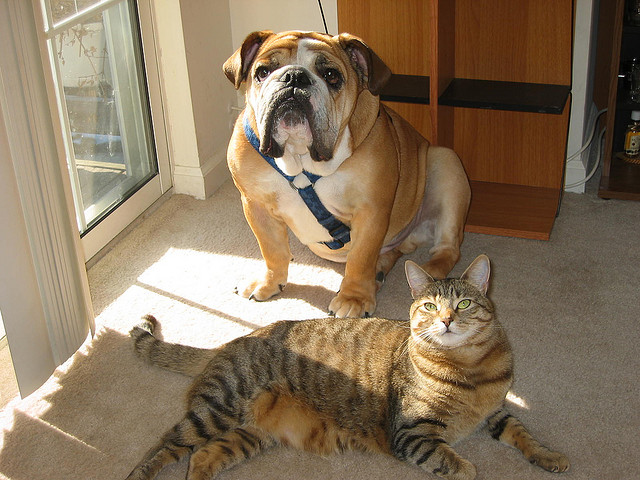

(640, 480, 'RGB')

In [5]:
image_path = os.path.join('../../', 'assets', 'cat_dog.jpg')
# image_path = os.path.join('../../', 'assets', 'cat_dog_cover.jpg')
image_raw = Image.open(image_path).convert('RGB')
display(image_raw)
image_raw.width, image_raw.height, image_raw.mode

### 数据增强

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
])

inputs = transform(image_raw).unsqueeze(0)
inputs.shape

torch.Size([1, 3, 224, 224])

### 加载模型并注册hooks

In [7]:
model = models.resnet18(pretrained=True)
# print(model)

candidate_layers = ['layer4']

fmap_pool = {}
grad_pool = {}

def save_fmaps(key):
    def forward_hook(module, _, output):
        fmap_pool[key] = output.detach()
    return forward_hook

def save_grads(key):
    def backward_hook(module, grad_in, grad_out):
        grad_pool[key] = grad_out[0].detach()
    return backward_hook

## 注册features map提取hook,以及梯度hook
handle_hooks = []
for name, module in model.named_modules():
    if name in candidate_layers:
        handle_hooks.append(module.register_forward_hook(save_fmaps(name)))
        handle_hooks.append(module.register_backward_hook(save_grads(name)))

### 获取卷积特征forward

In [8]:
model.eval()
out = model(inputs)
print(out.size())

# feature map
feature_map = fmap_pool[candidate_layers[0]]
feature_map.size()

torch.Size([1, 1000])


torch.Size([1, 512, 7, 7])

### 反向计算梯度backward

In [9]:
top3 = torch.topk(out, 3) # 242:dog 282:cat
print(top3)
target_idx = top3[1][0][0].item()

def obtain_gradient(idx):
    # one hot encoder
    one_hot = torch.zeros_like(out)
    one_hot.scatter_(1, torch.tensor([[idx]],dtype=torch.int64), 1.0)

    # gradient
    out.backward(gradient=one_hot, retain_graph=True)
    return grad_pool[candidate_layers[0]]

gradients = obtain_gradient(target_idx)
gradients.shape

torch.return_types.topk(
values=tensor([[17.6569, 17.3957, 16.9574]], grad_fn=<TopkBackward>),
indices=tensor([[242, 243, 282]]))


torch.Size([1, 512, 7, 7])

### 计算Alphas


$$
\alpha_k^c = \dfrac{1}{Z} \sum_{i}^{u} \sum_{j}^{v} \dfrac{\partial {y^c}}{\partial {A_{ij}^k}}
$$

In [10]:
# Alphas Averaging Gradients
alphas = F.adaptive_avg_pool2d(gradients, 1)
gradients.shape, alphas.shape, feature_map.shape

(torch.Size([1, 512, 7, 7]),
 torch.Size([1, 512, 1, 1]),
 torch.Size([1, 512, 7, 7]))

### 计算Grad-CAM

$$
L_{Grad-CAM}^c = ReLU\big( \sum_{k}^K \alpha_k^c A^k \big)
$$

In [11]:
gcam_raw = torch.mul(feature_map, alphas).sum(dim=1, keepdim=True)

# RELU:加强正影响(对目标类), 削弱负影响(其他分类)
gcam_raw = F.relu(gcam_raw)
gcam_raw -= torch.min(gcam_raw)
gcam_raw /= torch.max(gcam_raw)

### 可视化Grad-CAM

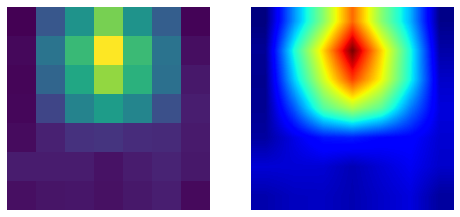

In [12]:
# B, C, H, W -> H, W
# gcam_map = gcam_raw[0, 0]
gcam_map = torch.squeeze(gcam_raw)

fig = plt.figure(figsize=(8, 8))

fig.add_subplot(1, 2, 1).axis("off")
plt.imshow(gcam_map)

# 224 x 224
gcam_map = F.interpolate(gcam_raw, size=224, mode="bilinear", align_corners=False).squeeze()

fig.add_subplot(1, 2, 2).axis("off")
plt.imshow(gcam_map, cmap='jet');

### 渲染Grad-CAM覆盖图

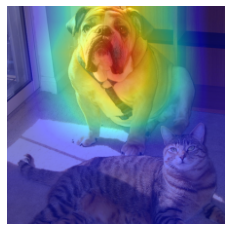

In [13]:
image_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
# [0 - 1]
image_org = np.array(image_trans(image_raw).permute(1, 2, 0))
# [0 - 1]
image_map = cm.jet(gcam_map.numpy())[..., :3]
gcam = (image_map + image_org) / 2
plt.axis("off")
plt.imshow(gcam, cmap='jet');

### Guided Backpropagation

In [14]:
model = models.resnet18(pretrained=True)
f_maps = []
def relu_backward_hook(module, grad_in, grad_out):
    fmap = f_maps.pop()
    # 特征0-1矫正(f_i > 0)
    fmap[fmap > 0] = 1
    # 消除负梯度
    modified_grad = fmap * torch.clamp(grad_in[0], min=0.0)
    return (modified_grad,)

def relu_forward_hook(module, _in, out):
    f_maps.append(out)
        
handle_hooks = []
for name, module in model.named_modules():
    if isinstance(module, torch.nn.ReLU):
        handle_hooks.append(module.register_backward_hook(relu_backward_hook))
        handle_hooks.append(module.register_forward_hook(relu_forward_hook))
        
inputs.requires_grad_()
model.eval()
out = model(inputs)
model.zero_grad()
one_hot_output = torch.FloatTensor(1, out.size()[-1]).zero_()
one_hot_output[0][target_idx] = 1
out.backward(gradient=one_hot_output)
gbp_raw = inputs.grad.clone().numpy()[0].transpose(1, 2, 0)
gbp_raw -= np.min(gbp_raw)
gbp_raw /= np.max(gbp_raw)

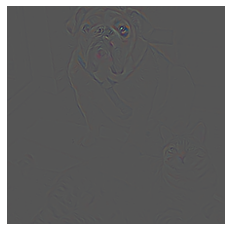

In [15]:
gbp_image = np.uint8(gbp_raw * 255)
gbp_image_gray = Image.fromarray(gbp_image).convert("L")
plt.axis('off')
plt.imshow(np.array(gbp_image), cmap='gray');

In [16]:
image_map.shape, gbp_raw.shape

((224, 224, 3), (224, 224, 3))

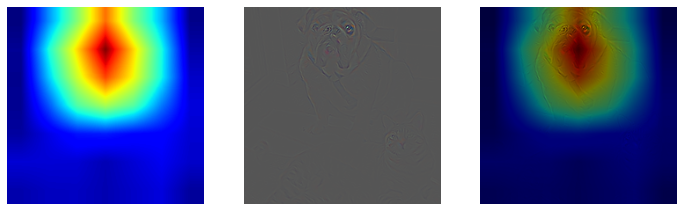

In [17]:
guided_grad_cam = np.multiply(image_map, gbp_raw)
guided_grad_cam -= np.min(guided_grad_cam)
guided_grad_cam /= np.max(guided_grad_cam)

fig = plt.figure(figsize=(12, 8))

fig.add_subplot(1, 3, 1).axis("off")
plt.imshow(image_map, cmap='gray')

fig.add_subplot(1, 3, 2).axis("off")
plt.imshow(gbp_raw, cmap='gray');

fig.add_subplot(1, 3, 3).axis("off")
plt.imshow(guided_grad_cam, cmap='gray');

## 参考 

[论文: Sanity Checks for Saliency Maps](https://arxiv.org/pdf/1810.03292.pdf)

[guided-grad-cam-is-broken](https://glassboxmedicine.com/2019/10/12/guided-grad-cam-is-broken-sanity-checks-for-saliency-maps/)

[译文: Grad-CAM](https://blog.csdn.net/stu_sun/article/details/80628406)

像素的强度变化对预测的分数有很大的影响

类别分数w.r.t像素强度的偏导数可视化，而导向反向传播[42]和反卷积[45]对“原始”梯度进行修改，从而改进质量。


评估模型可信度


弱监督定位

Grad-CAM是CAM的推广